# DBSCAN on public data, 5 classes

This notebook contains code to perform DBSCAN and analysis on a dataset of archeology

In [17]:
#can be removed
import nltk
from jupyterthemes import jtplot
jtplot.style()
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/amine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/amine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Load data

In [18]:
import pandas as pd

path = "../../all_dataset.csv"
df = pd.read_csv(path)

## 2. TF-IDF

In [19]:
import nltk
import re

# stopwords are already removed

from nltk.corpus import stopwords

stop_words=set(stopwords.words("french"))

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("french")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-ZÀ-ÿ]', token):
            if token not in stop_words:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-ZÀ-ÿ]', token):
            if token not in stop_words:
                filtered_tokens.append(token)
    return filtered_tokens

In [20]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in df.text:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df.text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(100, 1751)


## 4. Clustering with DBSCAN

In [22]:
from sklearn.cluster import DBSCAN

EPS = 0.75 # maximal distance 
MIN_SAMPLES = 3 # minimal amount of samples to form a cluster

clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(tfidf_matrix)
clusters = clustering.labels_.tolist()
y_pred_clus = clustering.fit_predict(tfidf_matrix)

## 5. Visualize clusters

Use SVD to reduce dimensions of points to only 2

In [23]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
data_2d = svd.fit_transform(tfidf_matrix)
data_2d.shape

(100, 2)

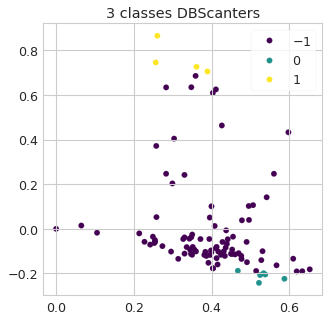

In [24]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(5,5))
scatter = plt.scatter(data_2d[:,0], data_2d[:,1], c=y_pred_clus)
plt.legend(*scatter.legend_elements())
plt.title("3 classes DBScanters")
plt.savefig("../../figures/3ClassesDBSCANClusters")
plt.show()

## Visualize actual classes

In [25]:
wiki=pd.DataFrame(list(zip(df['filename'],clusters)),columns=['filename','cluster'])
wiki.to_csv('../../3ClassesDBSCANClusters.csv', index=False)

In [26]:
wiki.cluster.unique()

array([-1,  0,  1])

Cluster: -1
Titles
                            PlanActionDD_MSSS_2016
                              PlanDD_Rio tinto2019
                                Rapport_CREDD_2019
                     Plan_QuébecEnvironnement_2020
                                  SADR_MRCDDR_2015
                        Rapport_AllianceVerte_2019
                                Rapport_CIDAL_2018
                     PlanAction_JardinMistouk_2017
                Mémoire_SommetÉcoRégionalSLSJ_2015
                      ACCUEILLIR_LA_PETITE_ENFANCE
                              Perspective_IMT_2011
                             Rapport_SADCLSJO_2019
                       Schéma_MRCDomaineduRoy_2015
                 Rapportd_activités_Alliage02_2019
                        Rapport_ForumPanetere_2018
    GuideDéveloppementDurable_BasseRésolution-2013
                                 Profil_MAPAQ_2020
                                  Plan_TIRSHV_2019
                        Objectif_VivreEnVille_2020
            

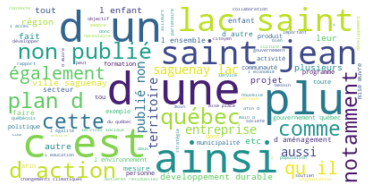

Cluster: 0
Titles
Rapport_Ville_de_Saguenay_cocréation_Hub_Versio...
Rapport_cocréation_MRC_LSJE_Hub_Version finale_...
Rapport_MRC_Maria-Chapdelaine_cocréation_Hub_Ve...
                  Rapport_régional_Hub_V15juin2020
         Rapport_DDR_cocréation_HUB_version_finale
               Rapport_Hub_Cocréation_Mashteuiatsh


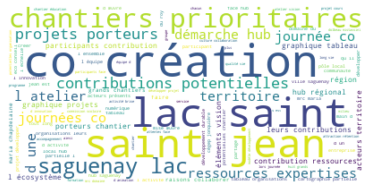

Cluster: 1
Titles
                     Rapport_ESSOR02_2019
           Rapport_MicroEntreprendre_2018
                      Rapport_SADCHS_2018
PolitiqueDD_OrchestreSymphoniqueSLSJ_2017


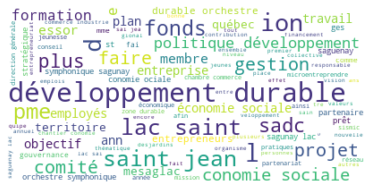

In [27]:
from wordcloud import WordCloud
result={'cluster':clusters,'wiki':list(df.text)}
result=pd.DataFrame(result)
for k in range(-1,2):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    filtered_words=[]
    for word in text.split():
        if re.search('[a-zA-ZÀ-ÿ]', word):
            if word not in stop_words:
                if len(word) > 2:
                    filtered_words.append(word)
    text=' '.join(filtered_words)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=wiki[wiki.cluster==k]['filename']         
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()